# Infection state prediction using generic channels

In this notebook I will try to predict an event's infection state using data from the generic channels (brightfield, side scatter / dark field and DAPI). The ground truth infection state has been manually gated based on a stain for MCP (= the viral probe), and for PSBA (= metabolic activity probe). the infection states are:
- MCP-/PSBA+ (= uninfected and showing metabolic activity)
- MCP+/PSBA+ (= infected and showing metabolic activity)
- MCP+/PSBA- (= infected and no longer showing metabolic activity)
- MCP-/PSBA- (= dead)

The features used to do this classification are derived from the images using two tools: IDEAS and SCIP. IDEAS is a proprietary software specifically designed for analysing ImageStream data. SCIP is an open-source software developed by me, aimed at providing image processing at scale. The features computed by both softwares are similar in nature.

Notes on the feature names of SCIP:
- If a feature name contains 'combined', it means it is computed on the combination of all channel masks (just like 'mc' in IDEAS features).
- If a feature name contains 'bgcorr', it means it is computed on the background substracted values of the image. This means the mean background pixel value is substracted from the pixels in the mask prior to feature computation.
- If a feature name containts 'edge', it means it is computed using the pixels that are on the edge of the mask.
- The SCIP bgcorr 'sum' features are the same as the IDEAS 'intensity' features. Both are computed by summing the background corrected pixel values in the mask.

# Package imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load common_.py
from common import *

In [3]:
import fcsparser
from ehv import feature_comparison, core
import flowutils
import shap
shap.initjs()

In [4]:
from sklearn.base import clone
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize, scale, minmax_scale, LabelEncoder, StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn import tree
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [5]:
from multiprocessing import Pool
from joblib import load
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from scipy.stats import spearmanr

In [106]:
from ehv.core import plot_gate_zarr

# Data import

Feature values from SCIP and IDEAS are imported. In total we import 133354 features.

In [41]:
data_dir = Path(os.environ["HOME"]) / "scratch/data/ehv"

In [42]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/weizmann/EhV/v2"

In [43]:
df_scip = pq.read_table(data_dir / f"results/scip/202201111300/features.parquet").to_pandas()
df_scip["meta_group"] = df_scip["meta_group"].astype(int)
df_scip["meta_replicate"] = df_scip["meta_replicate"].astype(int)
df_scip = df_scip[numpy.load(data_dir / "results/scip/202201111300/columns.npy", allow_pickle=True)]
df_scip = df_scip.loc[numpy.load(data_dir / "results/scip/202201111300/index.npy", allow_pickle=True)]
df_scip.shape

(125934, 1344)

In [44]:
# filter out cells for which no mask was found in the bbox channel
df_scip = df_scip[~df_scip["meta_bbox_minr"].isna()]
df_scip.shape

(125934, 1344)

In [45]:
df_scip = df_scip.drop(columns=df_scip.filter(regex="BF2$"))
df_scip.shape

(125934, 1132)

In [46]:
# ideas features
tmp = []
for p in Path(data_dir / "results/ideas/202111031041/").glob('*.fcs'):
    meta, data = fcsparser.parse(p)
    groups = re.search("^(?P<type>\w+)_T(?P<group>[0-9]+)_R(?P<replicate>[0-9]+)", p.name).groupdict()
    data["type"] = groups["type"]
    data["group"] = int(groups["group"])
    data["replicate"] = int(groups["replicate"])
    tmp.append(data)
df_ideas = pandas.concat(tmp, axis=0)

r = r"(?i).*(uncompensated|bkgd|saturation|\().*" 
todrop = list(filter(lambda x: re.match(r, x), df_ideas.columns))
df_ideas = df_ideas.drop(columns=todrop)

ideas_meta_cols = ["Object Number", "type", "group", "replicate"]
df_ideas = df_ideas.rename(columns=lambda col: f"meta_{col.lower()}" if col in ideas_meta_cols else f"feat_{col.lower()}")

df_ideas["meta_object_number"] = df_ideas["meta_object number"].astype(int)
df_ideas = df_ideas.drop(columns="meta_object number")

df_ideas.shape

(144421, 159)

In [47]:
df_ideas = df_ideas.drop(columns=df_ideas.filter(regex=".*(mcp|ch4).*").columns)
df_ideas.shape

(144421, 157)

In [48]:
df_scip = df_scip.set_index(["meta_object_number", "meta_replicate", "meta_group", "meta_type"])
df_ideas = df_ideas.set_index(["meta_object_number", "meta_replicate", "meta_group", "meta_type"])

In [49]:
df = df_scip.rename(columns=lambda a: "scip_"+a).join(
    df_ideas.rename(columns=lambda a: "ideas_"+a), 
    on=["meta_object_number", "meta_replicate", "meta_group", "meta_type"], 
    how="inner", lsuffix="ideas", rsuffix="scip"
)
df.shape

(125345, 1281)

In [50]:
def rename(c):
    if c.startswith("scip_meta"):
        return "meta_" + c[10:]
    return c
df = df.rename(columns=rename)

In [51]:
df["meta_label"] = pandas.Categorical(df["meta_label"], categories=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-", "unknown"], ordered=True)

# Interpreting the Extreme Gradient Boosting classifier

In [ ]:
model = joblib.load(data_dir / "results/scip/202201111300/xgb.joblib")

#### Feature importances of the decision trees

One way of interpreting the model is by looking at the features importances. Decision tree-based classifiers are constructed by iteratively splitting up the dataset based on an optimal value of a specific feature. This process continues until pure _leaves_ are obtained which contain only instances from one class. Througout the training process the algorithm records how many times a feature is used for splitting the set. A feature that is used often will have a high importance score.

In the table below, we can see the top 10 most important features used by the XGB model to predict the infection state based on the BF1, SSC and DAPI signals. We can see that these are mainly DAPI features. This is already an interesting observation, but it does not give us much further insight. For example, we don't know whether these features are equally important for classifying all infection states. It also does not indicate what specific values of a feature might lead to a certain state prediction.

To try to answer these questions, I look at the SHAP algorithm in the next section.

In [62]:
s = numpy.argsort(model.feature_importances_)
pandas.DataFrame(dict(feature = Xs.columns[s[-10:][::-1]], importance=model.feature_importances_[s[-10:][::-1]]))

,feature,importance
0,scip_feat_combined_bgcorr_edge_sum_DAPI,0.042249
1,scip_feat_bgcorr_lower_quartile_DAPI,0.029117
2,scip_feat_moments_hu-0_SSC,0.021595
3,scip_feat_combined_sobel_max_DAPI,0.020558
4,scip_feat_bgcorr_edge_sum_DAPI,0.019579
5,scip_feat_sobel_max_DAPI,0.017741
6,scip_feat_combined_edge_mean_BF1,0.015919
7,scip_feat_moments_hu-3_SSC,0.015504
8,scip_feat_bgcorr_kurtosis_DAPI,0.013734
9,scip_feat_kurtosis_DAPI,0.012030


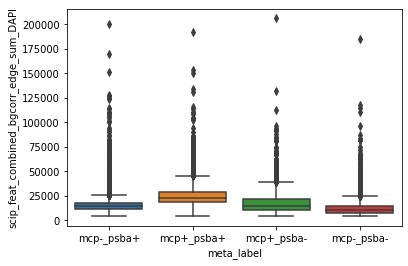

In [63]:
seaborn.boxplot(
    data=df_train,
    y=Xs.columns[s[-10:][::-1][0]],
    x="meta_label"
)

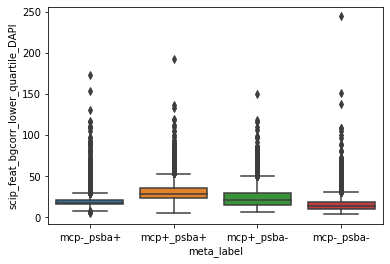

In [64]:
seaborn.boxplot(
    data=df_train,
    y=Xs.columns[s[-10:][::-1][1]],
    x="meta_label",
    hue_order=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"]
)

(-1e-05, 0.0001)

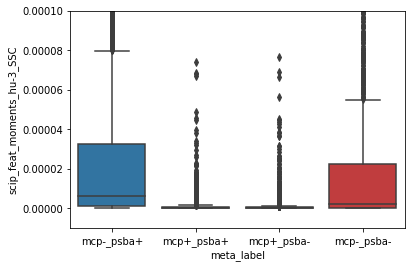

In [232]:
ax = seaborn.boxplot(
    data=df_train,
    y=Xs.columns[s[-10:][::-1][7]],
    x="meta_label",
    hue_order=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"]
)
ax.set_ylim(-0.00001, 0.0001)

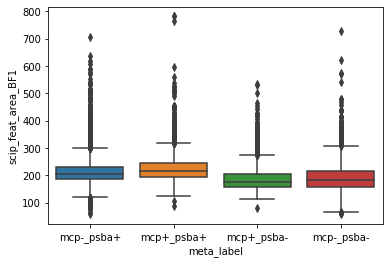

In [238]:
ax = seaborn.boxplot(
    data=df_train,
    y="scip_feat_area_BF1",
    x="meta_label",
    hue_order=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"]
)

#### SHAP analysis to identify features explaining cell states

In [83]:
# we only look at events that were correctly predicted by the model
Xs_correct = Xs_test[preds == y_test]
df_correct = df_test[preds == y_test]

In [67]:
numpy.random.seed(0)
explainer = shap.TreeExplainer(model)
shap_values = explainer(Xs_correct)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


To understand the SHAP algorithm, we first have to understand how a gradient boosting classifier works. In short, $N$ different decision trees are trained to predict a class from the input features. When a prediction needs to be made, each tree produces its prediction in the form of a vector containing negative and positive ones. In this setting, each output vector will contain 4 numbers (= amount of states) of which only one will be positive (= the state this decision tree thinks the input belongs to). The vectors from all the trees are then added using a weighted sum. This produces one vector containing for numbers. The class with the highest number is the one predicted by the gradient boosting model.

The SHAP algorithm then analyzes the trees in the gradient boosting model, and tries to attribute how much each feature with it's specific value contributed to the numbers that are output by the model. 

For example, the model outputs 8 for the MCP-/PSBA+ state for a particular input event. SHAP then assigns a value to each feature of the input sample. Features that drive the prediction to the MCP-/PSBA+ state get a high value, features that are unimportant get a low (possibly negative) value. The importance values from all the features summed together will be 8 (for that particular instance).

This way the SHAP analysis is similar to the feature importance above, but it gives us a much more detailed look into feature importances: for every value of every feature of every instance we get a particular importance score. 

The waterfall plot below, visualizes this idea. At the top we see that $f(x) = 5.646$, this is the value that the model outputs for this particular event for the MCP-/PSBA+ state. At the bottom we see that $E[f(x)] = 1.344$, this is the average value taken over all events that the model outputs for the MCP-/PSBA+ state. The difference between the average and predicted values is 'caused' by the particular values of the features of the event. Which features those are and what they contribute to the output is shown by the arrows in the plot. For example, the top contributing feature is the median absolute deviation of the edge of the cell in the brightfield channel with a value of 11. It is attributed an importance of -0.67, so it actually moves the prediction back towards the base average value. On the second row we see that the minor axis length of the cell computed on the brightfield channel mask with a value of 14.5 contributes positively to the prediction output. In the end, the effects of all features combined leads the model to predict that this input event is likely an MCP-/PSBA+ cell.

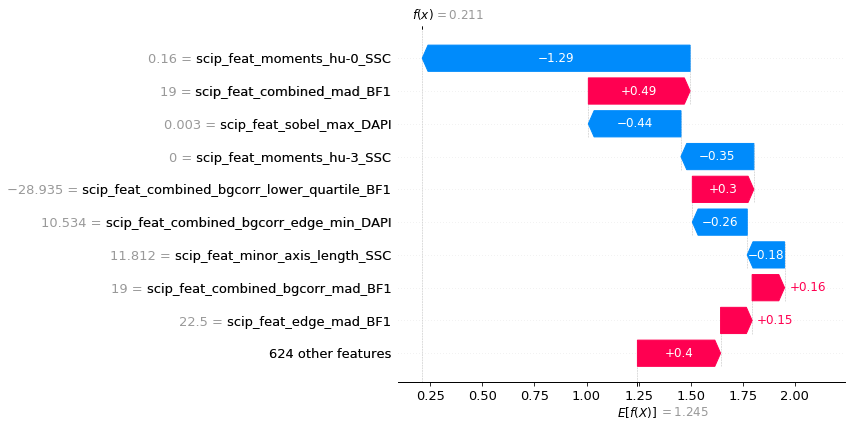

In [236]:
shap.plots.waterfall(shap_values[0, :, enc.transform(["mcp-_psba+"])[0]])

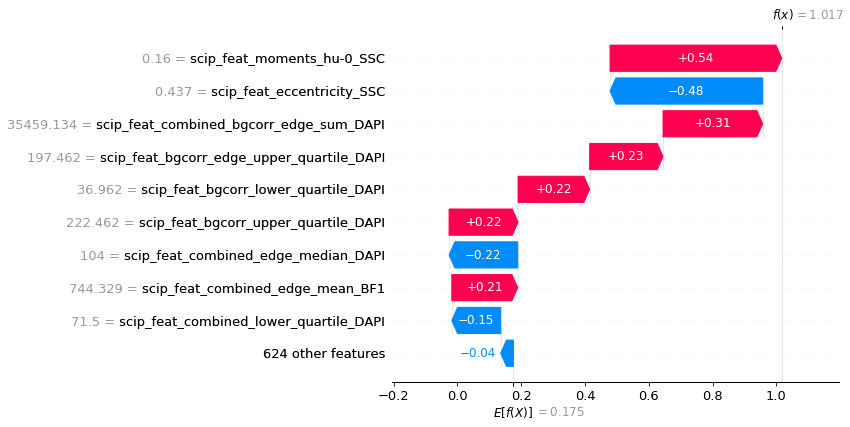

In [235]:
shap.plots.waterfall(shap_values[0, :, enc.transform(["mcp+_psba+"])[0]])

##### MCP-/PSBA+ events

Above, we saw an explanation for one event. Below, we see the beeswarm plot, which summarizes the contributions of the features for all events in the dataset. This is still for the MCP-/PSBA+ class. 

Each dot on the plot corresponds to one event. The color of the dot indicates the value of the feature for an event (low to high, blue to red). The rows are ordered according to average importance over the dataset. If a dot is to the left of the center-line, the feature contributes negatively to the event being classified in the MCP-/PSBA+ state. If it is on the right, it contributes positively (= making it more likely that an event would be classified as this state).

On the first row, we again find the MAD of the edge of cell in the BF channel. We can see that on average high values of this feature contribute positively to events being classified as MCP-/PSBA+. On the second row, we find the maximum value of the sobel map of the DAPI channel. The sobel map computes the gradient of neighbouring pixels in the image. A high maximum value of the sobel map means that the image contains a set of neighbouring pixels that have a large difference in intensity. If this feature is low, the neighbouring pixels are more uniform and don't change rapidly. Because the red dots are mainly to the left of the center line, we can derive that high values of this feature contribute negatively to an event being classified as MCP-/PSBA+. Events with a more uniform DAPI signal (= blue dots to the right of the center line) are more likely to be classified as MCP-/PSBA+ cells.

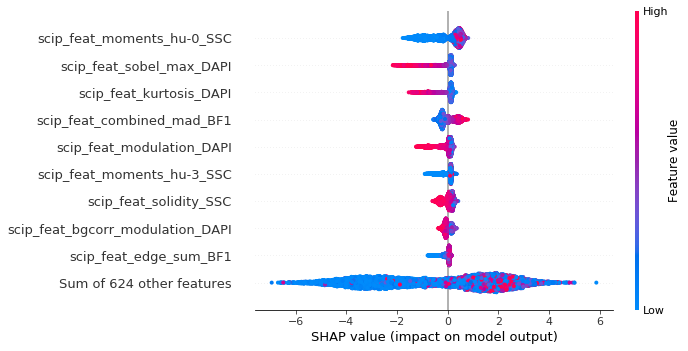

In [69]:
label = enc.transform(["mcp-_psba+"])[0]
shap.plots.beeswarm(shap_values[:, :, label])

A final new SHAP plot shown below, zooms in on one specific feature. It shows the feature's contribution to the prediction in function of the feature value. In the plot we look at the maximum sobel value in the DAPI channel. Each dot corresponds again to one event. This plot allows us to see patterns within the range of values that a feature can assume. 

On the X-axis we see the possible values of the feature in the dataset, and in gray the distribution of it. On the Y-axis, we see the contribution of the feature to the MCP-/PSBA+ state prediction. Ignoring the color of the dots for now, we can derive that as the maximum sobel value of the DAPI channel increases beyond approximately 150 the feature starts to contribute negatively to the MCP-/PSBA+ state. Events with a value less then 150 are thus more likely to be classified as MCP-/PSBA+.

A second aspect is the color. This color denotes the value of another feature, in this case kurtosis of the distribution of intensities in the DAPI channel. This feature interacts strongly with the maximum sobel value in the DAPI channel. For example, we can see that values that have a maximum sobel of less than 150 and a high kurtosis value have a smaller positive contribution towards MCP-/PSBA+ than the events with a low kurtosis value. So in biological terms this means that events with a uniform DAPI signal and a narrow distribution of DAPI intensities are more likely to be MCP-/PSBA+ events than those with a wide distribution of DAPI intensities. 

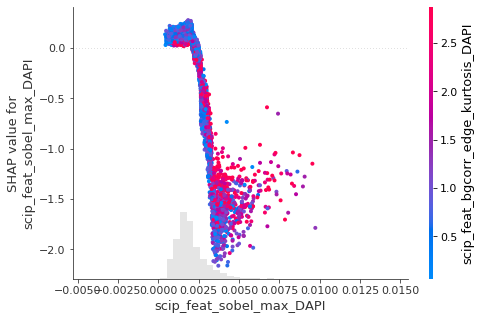

In [222]:
label = enc.transform(["mcp-_psba+"])[0]
sel1 = df_correct["scip_feat_sobel_max_DAPI"] < 0.01
shap.plots.scatter(
    shap_values[list(numpy.nonzero(sel1.values)[0]), "scip_feat_sobel_max_DAPI", label], 
    color=shap_values[list(numpy.nonzero(sel1.values)[0]), :, label]
)

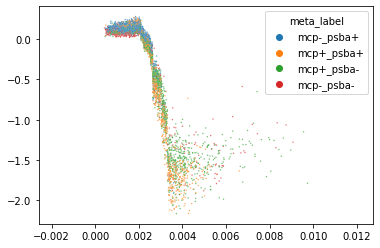

In [223]:
sel1 = df_correct["scip_feat_sobel_max_DAPI"] < 0.01
data = shap_values[list(numpy.nonzero(sel1.values)[0]), "scip_feat_sobel_max_DAPI", label].data
values = shap_values[list(numpy.nonzero(sel1.values)[0]), "scip_feat_sobel_max_DAPI", label].values
seaborn.scatterplot(x=data, y=values, hue=df_correct.loc[sel1, "meta_label"], edgecolors="none", s=2, alpha=0.7)

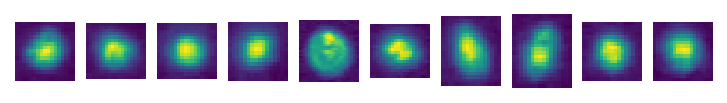

In [107]:
sel1 = df_correct["scip_feat_sobel_max_DAPI"] < 0.0005
plot_gate_zarr(sel1, df_correct, channel=4)

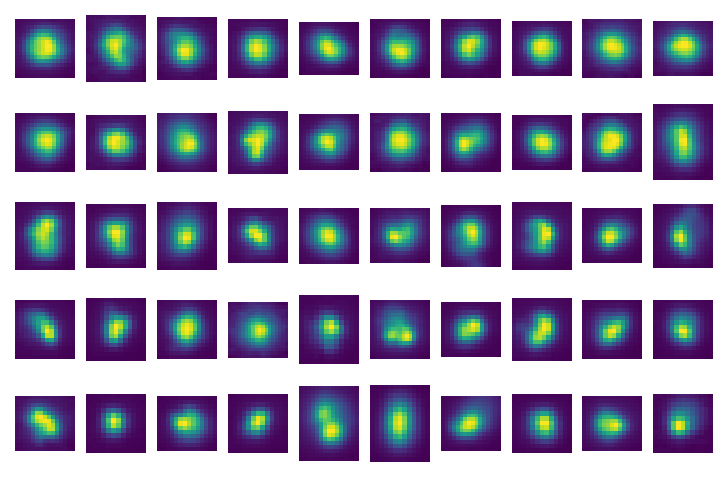

In [109]:
sel1 = df_correct["scip_feat_sobel_max_DAPI"] > 0.0075
plot_gate_zarr(sel1, df_correct, channel=4)

On a simple boxplot we can also see a hint of this split induced by the maximum value of the sobel map in the DAPI channel. The boxes corresponding to the infected states are indeed higher.

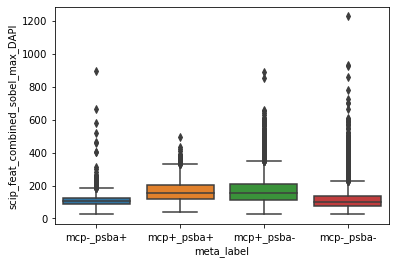

In [523]:
seaborn.boxplot(data=df.loc[:, :, :, "Inf"], x="meta_label", y="scip_feat_combined_sobel_max_DAPI")

The pattern is of course not always this clear. In the plot below, we see that low and high values of the mean values in the edge of the brightfield channel drive the events towards the MCP-/PSBA+ class, whereas events in the centre of the distribution drive the event away from this state.

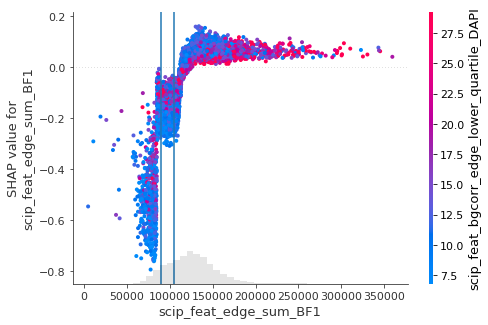

In [131]:
label = enc.transform(["mcp-_psba+"])[0]
fig, ax = plt.subplots(figsize=(7.5, 5))
ax.axvline(90000)
ax.axvline(105000)
shap.plots.scatter(shap_values[:, "scip_feat_edge_sum_BF1", label], color=shap_values[:, :, label], ax=ax)

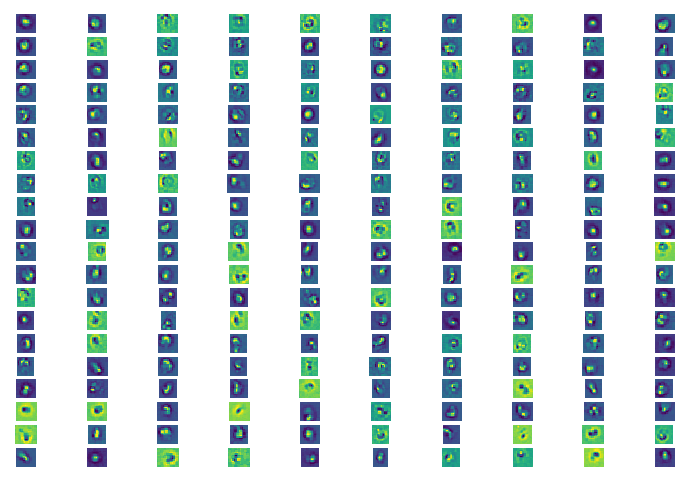

In [132]:
sel1 = df_correct["scip_feat_edge_sum_BF1"] > 90000
sel2 = df_correct["scip_feat_edge_sum_BF1"] < 105000
plot_gate_zarr(sel1 & sel2, df_correct, channel=0)

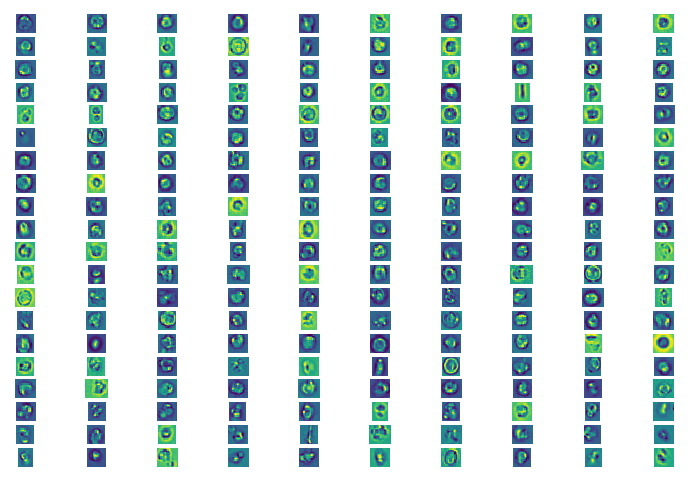

In [133]:
sel1 = df_correct["scip_feat_edge_sum_BF1"] > 150000
plot_gate_zarr(sel1, df_correct, channel=0)

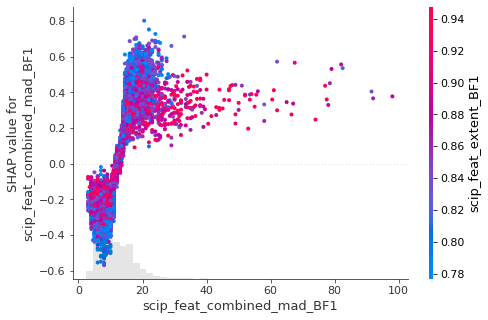

In [134]:
label = enc.transform(["mcp-_psba+"])[0]
fig, ax = plt.subplots(figsize=(7.5, 5))
shap.plots.scatter(shap_values[:, "scip_feat_combined_mad_BF1", label], color=shap_values[:, :, label], ax=ax)

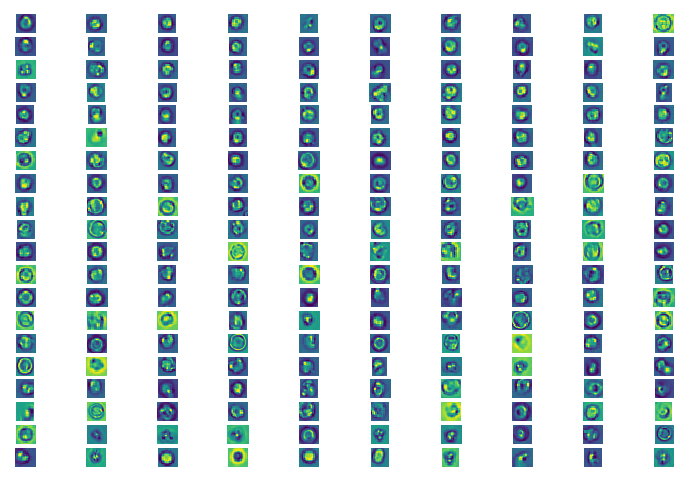

In [135]:
sel1 = df_correct["scip_feat_combined_mad_BF1"] > 20
plot_gate_zarr(sel1, df_correct, channel=0)

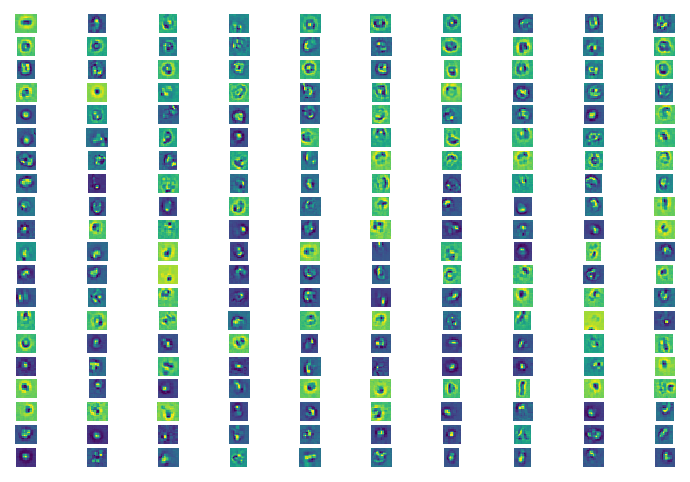

In [141]:
sel1 = df_correct["scip_feat_combined_mad_BF1"] < 10
sel2 = df_correct["scip_feat_extent_BF1"] < 0.8
plot_gate_zarr(sel1, df_correct, channel=0)

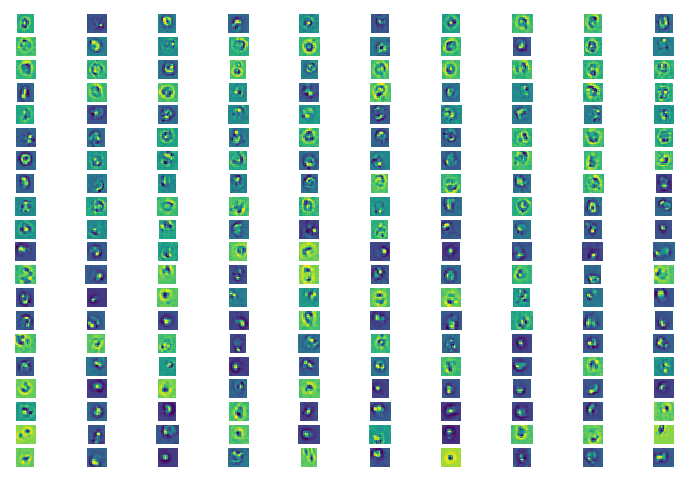

In [142]:
sel1 = df_correct["scip_feat_combined_mad_BF1"] < 10
sel2 = df_correct["scip_feat_extent_BF1"] > 0.9
plot_gate_zarr(sel1, df_correct, channel=0)

##### MCP+/PSBA+ events

Below we show SHAP plots for the MCP+/PSBA+ state.

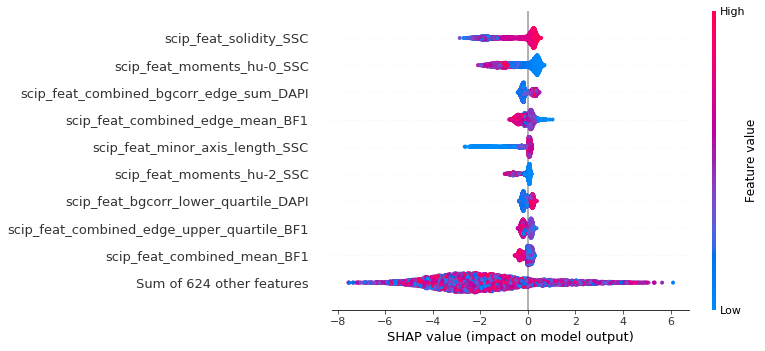

In [143]:
label = enc.transform(["mcp+_psba+"])[0]
shap.plots.beeswarm(shap_values[:, :, label])

In [144]:
numpy.nonzero(y_test == enc.transform(["mcp+_psba+"])[0])[0]

array([   0,    2,    6, ..., 9472, 9476, 9479])

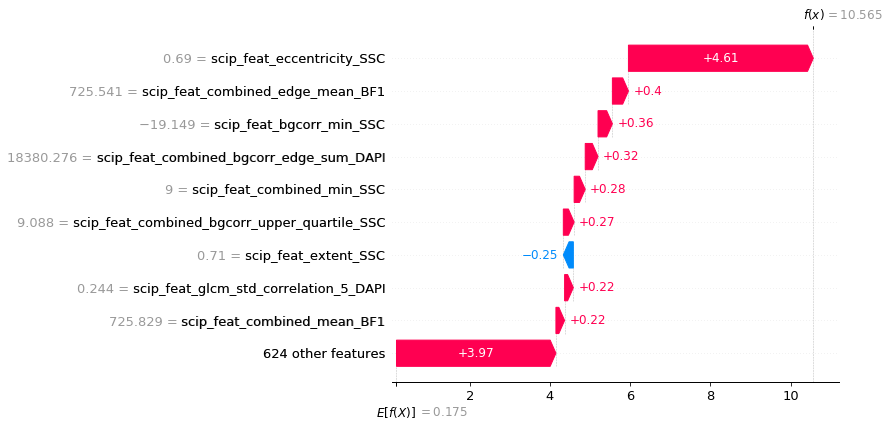

In [146]:
shap.plots.waterfall(shap_values[2, :, enc.transform(["mcp+_psba+"])[0]])

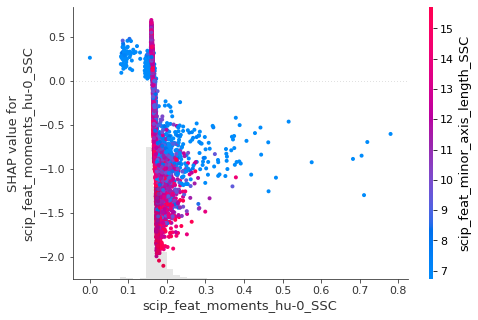

In [217]:
label = enc.transform(["mcp+_psba+"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_moments_hu-0_SSC", label], color=shap_values[:, :, label])

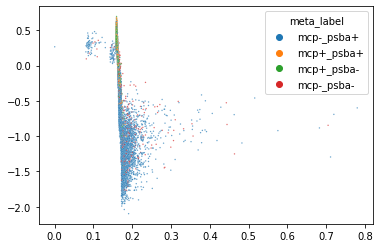

In [218]:
data = shap_values[:, "scip_feat_moments_hu-0_SSC", label].data
values = shap_values[:, "scip_feat_moments_hu-0_SSC", label].values
seaborn.scatterplot(x=data, y=values, hue=df_correct["meta_label"], edgecolors="none", s=2, alpha=0.7)

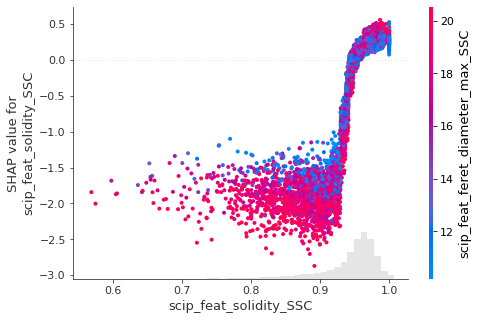

In [170]:
label = enc.transform(["mcp+_psba+"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_solidity_SSC", label], color=shap_values[:, :, label])

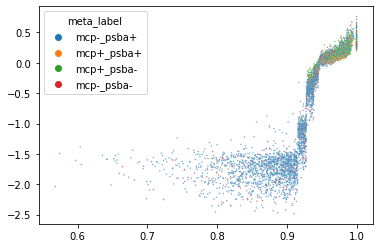

In [216]:
data = shap_values[:, "scip_feat_solidity_SSC", label].data
values = shap_values[:, "scip_feat_solidity_SSC", label].values
seaborn.scatterplot(x=data, y=values, hue=df_correct["meta_label"], edgecolors="none", s=2, alpha=0.7)

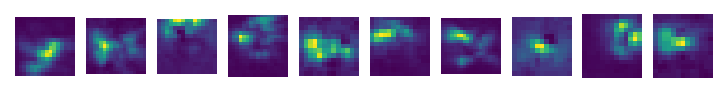

In [154]:
sel1 = df_correct["scip_feat_solidity_SSC"] > 0.95
plot_gate_zarr(sel1, df_correct, channel=3, maxn=10)

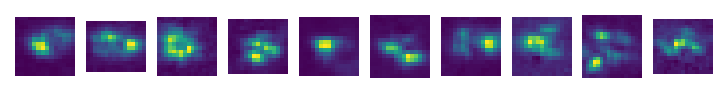

In [158]:
sel1 = df_correct["scip_feat_solidity_SSC"] < 0.8
plot_gate_zarr(sel1, df_correct, channel=3, maxn=10)

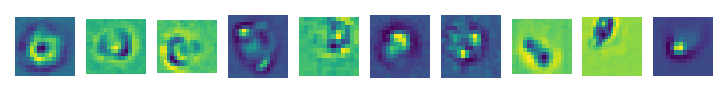

In [155]:
sel1 = df_correct["scip_feat_solidity_SSC"] > 0.95
plot_gate_zarr(sel1, df_correct, channel=0, maxn=10)

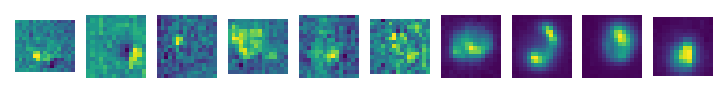

In [156]:
sel1 = df_correct["scip_feat_solidity_SSC"] > 0.95
plot_gate_zarr(sel1, df_correct, channel=1, maxn=10)

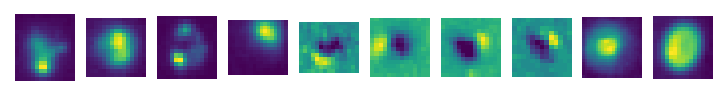

In [157]:
sel1 = df_correct["scip_feat_solidity_SSC"] > 0.95
plot_gate_zarr(sel1, df_correct, channel=6, maxn=10)

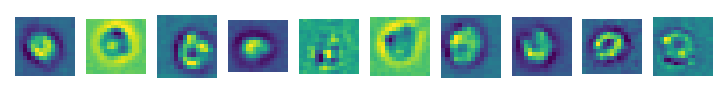

In [159]:
sel1 = df_correct["scip_feat_solidity_SSC"] < 0.8
plot_gate_zarr(sel1, df_correct, channel=0, maxn=10)

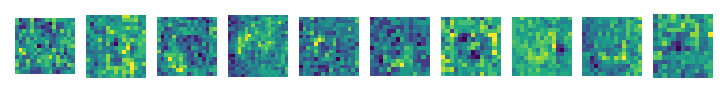

In [160]:
sel1 = df_correct["scip_feat_solidity_SSC"] < 0.8
plot_gate_zarr(sel1, df_correct, channel=1, maxn=10)

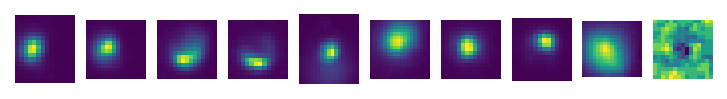

In [161]:
sel1 = df_correct["scip_feat_solidity_SSC"] < 0.8
plot_gate_zarr(sel1, df_correct, channel=6, maxn=10)

##### MCP+/PSBA- events

Below we show SHAP plots for the MCP+/PSBA- state.

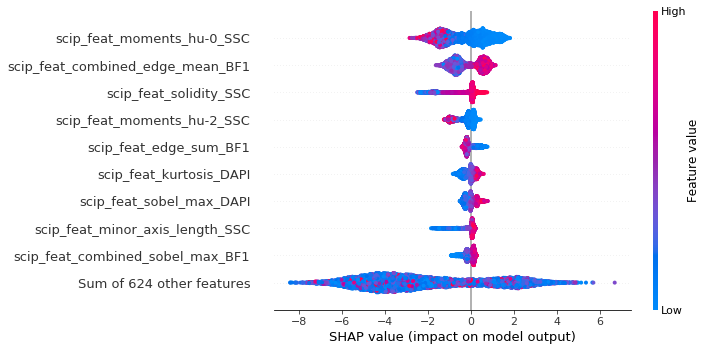

In [171]:
label = enc.transform(["mcp+_psba-"])[0]
shap.plots.beeswarm(shap_values[:, :, label])

In [189]:
list(set(numpy.nonzero(y_test == enc.transform(["mcp+_psba-"])[0])[0]).intersection(numpy.nonzero(y_test == preds)[0]))[0]

8193

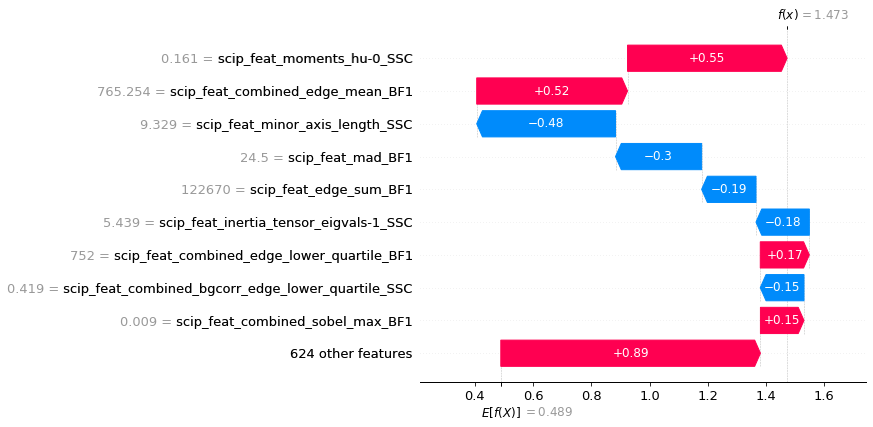

In [190]:
shap.plots.waterfall(shap_values[8193, :, enc.transform(["mcp+_psba-"])[0]])

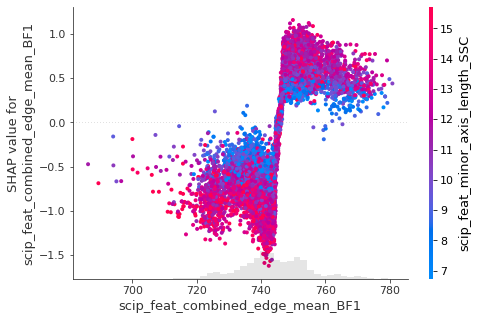

In [191]:
label = enc.transform(["mcp+_psba-"])[0]
shap.plots.scatter(shap_values[:, "scip_feat_combined_edge_mean_BF1", label], color=shap_values[:, :, label])

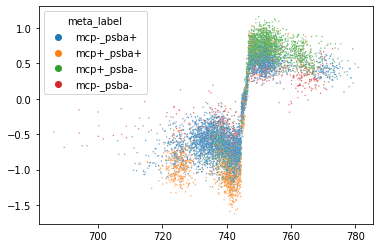

In [205]:
data = shap_values[:, "scip_feat_combined_edge_mean_BF1", label].data
values = shap_values[:, "scip_feat_combined_edge_mean_BF1", label].values
seaborn.scatterplot(x=data, y=values, hue=df_correct["meta_label"], edgecolors="none", s=2, alpha=0.7)

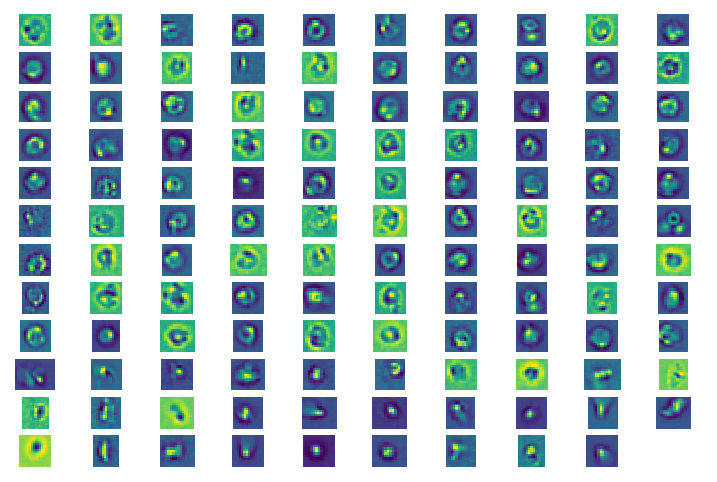

In [194]:
sel1 = df_correct["scip_feat_combined_edge_mean_BF1"] > 770
plot_gate_zarr(sel1, df_correct, channel=0)

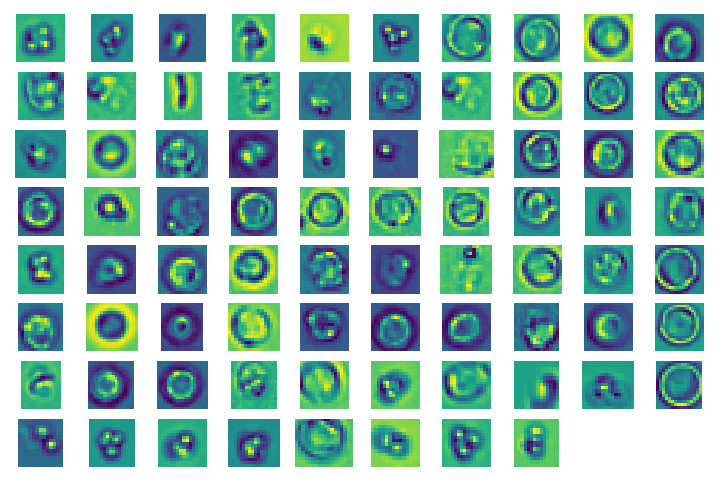

In [195]:
sel1 = df_correct["scip_feat_combined_edge_mean_BF1"] < 720
plot_gate_zarr(sel1, df_correct, channel=0)

# Discussion

The XGB model was then analysed more in-depth by looking at the feature importances and performing a SHAP analysis. Using SHAP a number of features in the BF, SSC and DAPI channel were identified that drive prediction of the infection states. Mainly the DAPI and BF channel contain information that makes prediction possible. Overall, features derived from the intensity values are the most informative. For example, maximum/minimum value in the sobel map, and various statistics of the (edge) intensities. From the shape features only the minor axis length showed up in the most informative features. The GLCM texture features seem fairly uninformative for this task.